In [4]:
#! pip install scikit-optimize

# Tuning a scikit-learn estimator with skopt

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem statement
Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using sklearn.model_selection.GridSearchCV), which often results in a very time consuming operation.

In this notebook, we illustrate how to couple gp_minimize with sklearn's estimators to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations.

## Objective
To tune the hyper-parameters of our model we need to define a model, decide which parameters to optimize, and define the objective function we want to minimize.

In [6]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

/Users/gho/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Next, we need to define the bounds of the dimensions of the search space we want to explore and pick the objective. In this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters.

In [7]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

## Optimize all the things!
With these two pieces, we are now ready for sequential model-based optimisation. Here we use gaussian process-based optimisation.

In [17]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=200, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.9118'

In [18]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.134463
- max_features=13
- min_samples_split=100
- min_samples_leaf=3


## Convergence plot

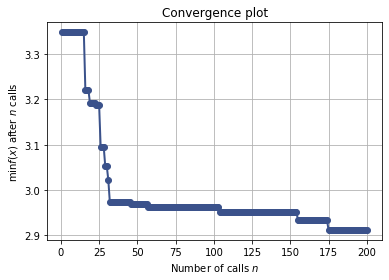

In [23]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

## Visualizing optimization results

In [24]:
np.random.seed(123)
plt.set_cmap("viridis")

<Figure size 432x288 with 0 Axes>

Bayesian optimization or sequential model-based optimization uses a surrogate model to model the expensive to evaluate objective function func. It is this model that is used to determine at which points to evaluate the expensive objective next.

To help understand why the optimization process is proceeding the way it is, it is useful to plot the location and order of the points at which the objective is evaluated. If everything is working as expected, early samples will be spread over the whole parameter space and later samples should cluster around the minimum.

The plot_evaluations() function helps with visualizing the location and order in which samples are evaluated for objectives with an arbitrary number of dimensions.

The plot_objective() function plots the partial dependence of the objective, as represented by the surrogate model, for each dimension and as pairs of the input dimensions.

All of the minimizers implemented in skopt return an OptimizeResult instance that can be inspected. Both plot_evaluations and plot_objective are helpers that do just that.

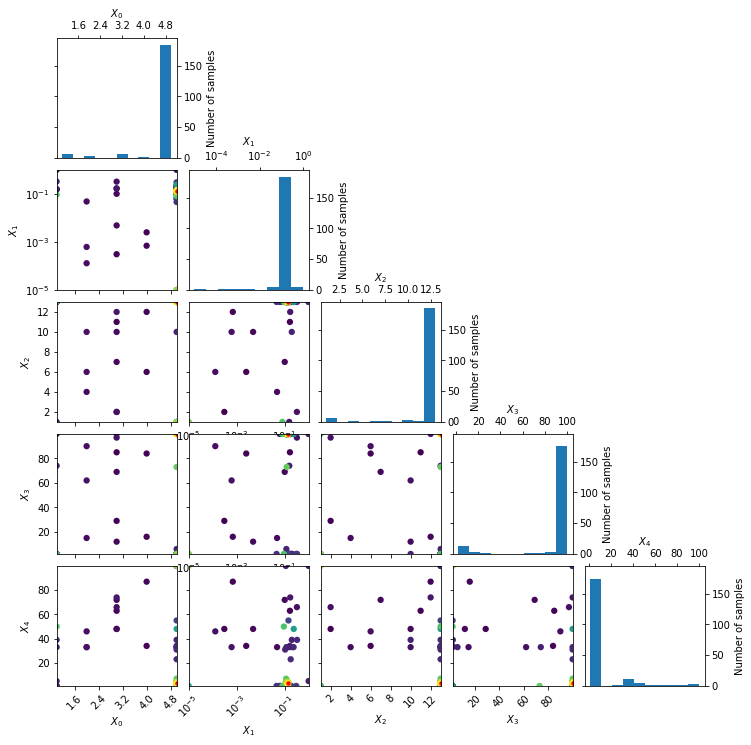

In [28]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(res_gp, bins=10)

plot_evaluations() creates a grid of size n_dims by n_dims. The diagonal shows histograms for each of the dimensions. In the lower triangle (just one plot in this case) a two dimensional scatter plot of all points is shown. The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process.

You should be able to see that points start clustering around the location of the true miminum. The histograms show that the objective is evaluated more often at locations near to one of the three minima.

Using plot_objective() we can visualise the one dimensional partial dependence of the surrogate model for each dimension. The contour plot in the bottom left corner shows the two dimensional partial dependence. In this case this is the same as simply plotting the objective as it only has two dimensions.

Partial dependence plots were proposed by Friedman (2001) (doi:10.1214/aos/1013203451 section 8.2) as a method for interpreting the importance of input features used in gradient boosting machines. Given a function of $k$ variables $y=f\left(x_1, x_2, ..., x_k\right)$ the partial dependence of $f$ on the $i$-th variable $x_i$ is calculated as:$$\phi\left( x_i \right) = \frac{1}{N} \sum^N_{j=0}f\left(x_{1,j}, x_{2,j}, ..., x_i, ..., x_{k,j}\right)$$with the sum running over a set of $N$ points drawn at random from the search space.

The idea is to visulize how the value of $x_j$ influences the function $f$ after averaging out the influence of all other variables.

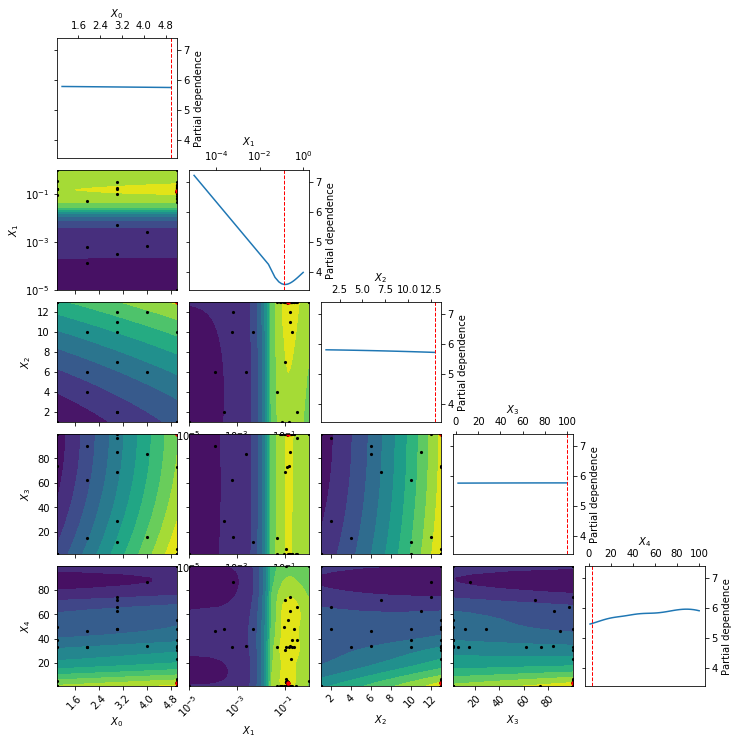

In [29]:
from skopt.plots import plot_objective

_ = plot_objective(res_gp)

The two dimensional partial dependence plot can look like the true objective but it does not have to. As points at which the objective function is being evaluated are concentrated around the suspected minimum the surrogate model sometimes is not a good representation of the objective far away from the minima.